# Embeddings

Import libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Some Matplotlib configuration:

In [2]:
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 20 }
plt.rc('font', **font)

Import the config file which contains all the paths:

In [3]:
import sys

In [4]:
sys.path.append('..')

In [5]:
import config

Random seed:

In [6]:
np.random.seed(42)

**Captions**

In [7]:
config.DEV_CAPTIONS

'/datasets/dev-set/dev-set_video-captions.txt'

In [8]:
dev_captions = pd.read_csv(config.DEV_CAPTIONS, sep = '\t', header=None, names=['video', 'caption'] )

In [9]:
dev_captions.shape

(8000, 2)

In [10]:
dev_captions.head()

,video,caption
0,video10.webm,couple-relaxing-on-picnic-crane-shot
1,video100.webm,cute-black-and-white-cats-in-cage-at-animal-sh...
2,video10000.webm,owl-in-tree-close-up
3,video10001.webm,around-the-house-on-a-laptop
4,video10002.webm,beautiful-young-girl-with-apple


In [11]:
dev_captions["caption"] = dev_captions["caption"].str.split('-').apply(' '.join)

In [12]:
dev_captions["caption"].head()

0                 couple relaxing on picnic crane shot
1    cute black and white cats in cage at animal sh...
2                                 owl in tree close up
3                         around the house on a laptop
4                      beautiful young girl with apple
Name: caption, dtype: object

**Groundtruth**

In [13]:
dev_ground_truth = pd.read_csv(config.DEV_GROUNDTRUTH) 

Merging both datasets:

In [14]:
dev_captions = dev_captions.merge(dev_ground_truth)

In [15]:
dev_captions.head()

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video10.webm,couple relaxing on picnic crane shot,0.950,34,0.900,10
1,video100.webm,cute black and white cats in cage at animal sh...,0.951,33,0.889,9
2,video10000.webm,owl in tree close up,0.832,33,1.000,13
3,video10001.webm,around the house on a laptop,0.865,33,0.727,11
4,video10002.webm,beautiful young girl with apple,0.899,59,0.792,24


In [16]:
captions = dev_captions["caption"].tolist()

In [17]:
caption_words = list(set([ word for caption in captions for word in caption.split() ]))

In [18]:
'{:,} words in the dev captions'.format(len(caption_words))

'5,874 words in the dev captions'

In [19]:
caption_words[:5]

['multiracial', 'laughing', 'mazefield', 'straws', 'lined']

In [20]:
short_labels = dev_captions['short-term_memorability'].tolist()

In [21]:
short_labels[:5]

[0.95, 0.951, 0.8320000000000001, 0.865, 0.899]

**Pre-trained embeddings**

In [22]:
DATA_DIR = '../../data'
GLOVE_FILE = 'glove.6B.100d.txt'

In [23]:
os.path.join(DATA_DIR,  GLOVE_FILE)

'../../data/glove.6B.100d.txt'

In [24]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(DATA_DIR, GLOVE_FILE)) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

Indexing word vectors.


In [25]:
print('Found %s word vectors.' % len(embeddings_index))

Found 5446 word vectors.


In [26]:
words = list(embeddings_index.keys())

In [27]:
vectors = list(embeddings_index.values())

In [28]:
from sklearn.decomposition import PCA

def get_pca(vectors):

    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(vectors)
    print('PCA explained variance ratio:', pca.explained_variance_ratio_, 
          'Total:', sum(pca.explained_variance_ratio_))
    return principal_components

In [29]:
pca_vectors = get_pca(vectors)

PCA explained variance ratio: [0.09785616 0.03638099] Total: 0.13423715615186022


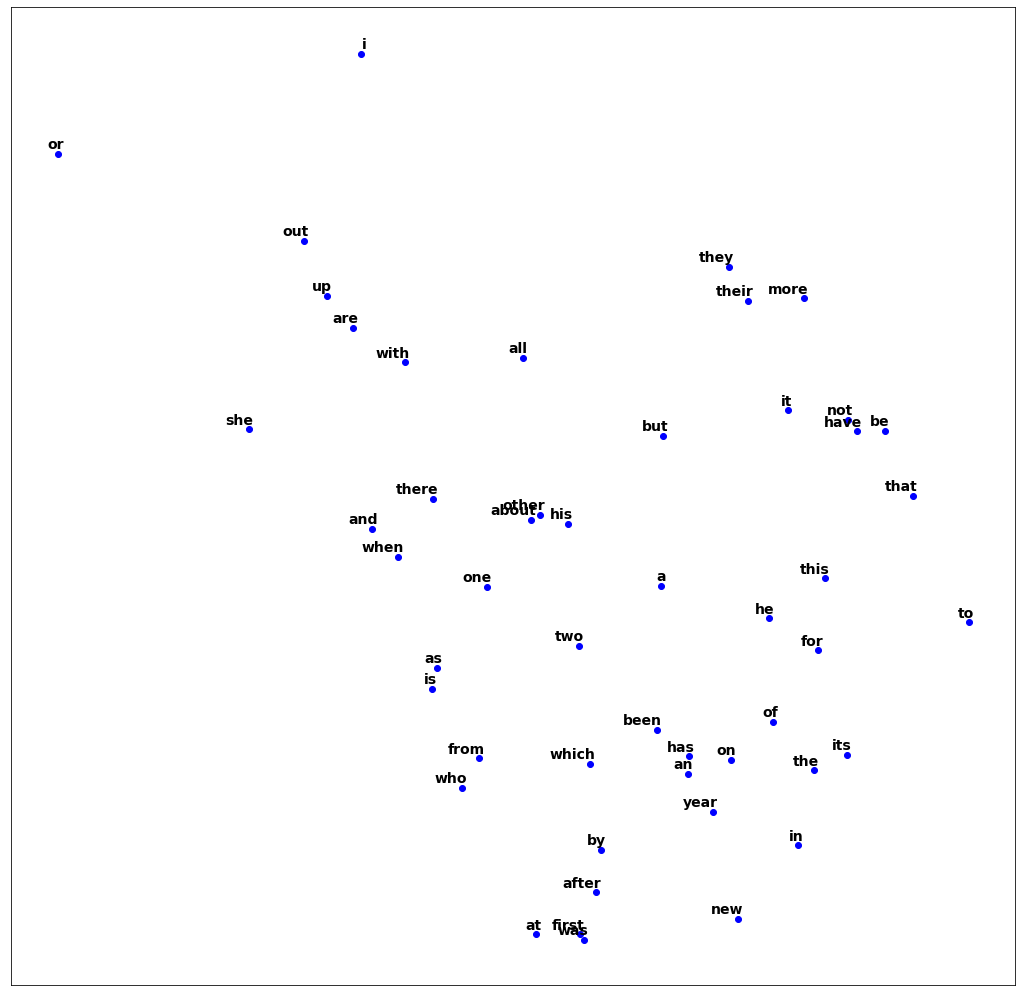

In [30]:
N = 50

plt.figure(figsize=(18, 18))
ax = plt.axes()
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
i = 0
while i < len(pca_vectors[:N]):
    # Vector
    x, y = pca_vectors[i, :]
    # Word
    word = words[i]
    # Plot
    plt.scatter(x, y, color='b')
    plt.annotate(word,
                xy=(x, y),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom',
                fontsize=14)
    i += 1

plt.savefig('../../figures/GloVe_PCA_Top_50.png')

**Modelling**

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [32]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

In [33]:
tokenizer.word_index['in']

1

In [34]:
sequences = tokenizer.texts_to_sequences(captions)

In [35]:
captions[0]

'couple relaxing on picnic crane shot'

In [36]:
sequences[0]

[15, 117, 3, 597, 347, 25]

In [37]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5874 unique tokens.


In [38]:
MAX_NUM_WORDS = len(word_index)

In [39]:
MAX_SEQUENCE_LENGTH = max([ len(caption.split()) for caption in captions ])
MAX_SEQUENCE_LENGTH

37

In [40]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [41]:
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8000, 37)


In [42]:
Y = np.array(short_labels)

In [43]:
print('Len of label tensor:', Y.shape)

Len of label tensor: (8000,)


In [44]:
from sklearn.model_selection import train_test_split

print('[INFO] Splitting data between train (70%), validation (20%) and test (10%) sets...')

X_train, X_val_test, y_train, y_val_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=1./3,
    random_state=42)

[INFO] Splitting data between train (70%), validation (20%) and test (10%) sets...


In [45]:
X_train.shape, X_val.shape, X_test.shape

((6400, 37), (1066, 37), (534, 37))

In [46]:
y_train.shape, y_val.shape, y_test.shape

((6400,), (1066,), (534,))

In [47]:
EMBEDDING_DIM = 100

In [48]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [49]:
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten, GRU
from keras.models import Model
from keras.initializers import Constant

In [50]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [51]:
print('Training model.')

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = GRU(units=32, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
preds = Dense(1, activation='sigmoid')(x)

Training model.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [52]:
model = Model(sequence_input, preds)

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 37)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 37, 100)           587500    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 600,301
Trainable params: 12,801
Non-trainable params: 587,500
_________________________________________________________________


In [54]:
from keras.optimizers import Adam

opt = Adam(lr=1e-3, decay=1e-3 / 200)

In [55]:
model.compile(loss='mean_absolute_error',
              optimizer=opt, 
              metrics=['mean_squared_error'])

In [56]:
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=30, 
          shuffle=False,
)

Instructions for updating:
Use tf.cast instead.
Train on 6400 samples, validate on 1066 samples
Epoch 1/30
6400/6400 [==============================] - 5s 793us/step - loss: 0.0897 - mean_squared_error: 0.0163 - val_loss: 0.0664 - val_mean_squared_error: 0.0076
Epoch 2/30
6400/6400 [==============================] - 4s 664us/step - loss: 0.0618 - mean_squared_error: 0.0066 - val_loss: 0.0618 - val_mean_squared_error: 0.0065
Epoch 3/30
6400/6400 [==============================] - 4s 677us/step - loss: 0.0589 - mean_squared_error: 0.0059 - val_loss: 0.0601 - val_mean_squared_error: 0.0060
Epoch 4/30
6400/6400 [==============================] - 4s 692us/step - loss: 0.0577 - mean_squared_error: 0.0057 - val_loss: 0.0592 - val_mean_squared_error: 0.0058
Epoch 5/30
6400/6400 [==============================] - 4s 674us/step - loss: 0.0568 - mean_squared_error: 0.0055 - val_loss: 0.0591 - val_mean_squared_error: 0.0058
Epoch 6/30
6400/6400 [==============================] - 4s 679us/step - lo

In [57]:
preds = model.predict(X_test)

In [58]:
# preds.flatten()

In [59]:
from scipy.stats import spearmanr

In [60]:
spearmanr(y_test, preds)

SpearmanrResult(correlation=0.42775131884062756, pvalue=3.6238515708131418e-25)